<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/tutorials/W1D4_DimensionalityReduction/W1D4_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W1D4_DimensionalityReduction/W1D4_Tutorial2.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 2: Principal Component Analysis

**Week 1, Day 4: Dimensionality Reduction**

**By Neuromatch Academy**

__Content creators:__ Alex Cayco Gajic, John Murray

__Content reviewers:__ Roozbeh Farhoudi, Matt Krause, Spiros Chavlis, Richard Gao, Michael Waskom, Siddharth Suresh, Natalie Schaworonkow, Ella Batty


<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial Objectives

*Estimated timing of tutorial: 45 minutes*

In this notebook we'll learn how to perform PCA by projecting the data onto the eigenvectors of its covariance matrix. 

Overview:
- Calculate the eigenvectors of the sample covariance matrix.
- Perform PCA by projecting data onto the eigenvectors of the covariance matrix. 
- Plot and explore the eigenvalues.

To quickly refresh your knowledge of eigenvalues and eigenvectors, you can watch this [short video](https://www.youtube.com/watch?v=kwA3qM0rm7c) (4 minutes) for a geometrical explanation. For a deeper understanding, this [in-depth video](https://www.youtube.com/watch?v=PFDu9oVAE-g&list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab&index=14) (17 minutes) provides an excellent basis and is beautifully illustrated.

In [1]:
# @title Tutorial slides

# @markdown These are the slides for the videos in all tutorials today
from IPython.display import IFrame
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/kaq2x/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

In [2]:
# @title Video 1: PCA
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1hK411H7Zi", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="-f6T9--oM0E", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

---
# Setup


In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# @title Figure Settings
import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [5]:
# @title Plotting Functions

def plot_eigenvalues(evals):
  """
  Plots eigenvalues.

  Args:
      (numpy array of floats) : Vector of eigenvalues

  Returns:
    Nothing.

  """
  plt.figure(figsize=(4, 4))
  plt.plot(np.arange(1, len(evals) + 1), evals, 'o-k')
  plt.xlabel('Component')
  plt.ylabel('Eigenvalue')
  plt.title('Scree plot')
  plt.xticks(np.arange(1, len(evals) + 1))
  plt.ylim([0, 2.5])


def plot_data(X):
  """
  Plots bivariate data. Includes a plot of each random variable, and a scatter
  scatter plot of their joint activity. The title indicates the sample
  correlation calculated from the data.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

  Returns:
    Nothing.
  """

  fig = plt.figure(figsize=[8, 4])
  gs = fig.add_gridspec(2, 2)
  ax1 = fig.add_subplot(gs[0, 0])
  ax1.plot(X[:, 0], color='k')
  plt.ylabel('Neuron 1')
  ax2 = fig.add_subplot(gs[1, 0])
  ax2.plot(X[:, 1], color='k')
  plt.xlabel('Sample Number (sorted)')
  plt.ylabel('Neuron 2')
  ax3 = fig.add_subplot(gs[:, 1])
  ax3.plot(X[:, 0], X[:, 1], '.', markerfacecolor=[.5, .5, .5],
           markeredgewidth=0)
  ax3.axis('equal')
  plt.xlabel('Neuron 1 activity')
  plt.ylabel('Neuron 2 activity')
  plt.title('Sample corr: {:.1f}'.format(np.corrcoef(X[:, 0], X[:, 1])[0, 1]))
  plt.show()


def plot_data_new_basis(Y):
  """
  Plots bivariate data after transformation to new bases. Similar to plot_data
  but with colors corresponding to projections onto basis 1 (red) and
  basis 2 (blue).
  The title indicates the sample correlation calculated from the data.

  Note that samples are re-sorted in ascending order for the first random
  variable.

  Args:
    Y (numpy array of floats) : Data matrix in new basis each column
                                corresponds to a different random variable

  Returns:
    Nothing.
  """

  fig = plt.figure(figsize=[8, 4])
  gs = fig.add_gridspec(2, 2)
  ax1 = fig.add_subplot(gs[0, 0])
  ax1.plot(Y[:, 0], 'r')
  plt.ylabel('Projection \n basis vector 1')
  ax2 = fig.add_subplot(gs[1, 0])
  ax2.plot(Y[:, 1], 'b')
  plt.xlabel('Sample number')
  plt.ylabel('Projection \n basis vector 2')
  ax3 = fig.add_subplot(gs[:, 1])
  ax3.plot(Y[:, 0], Y[:, 1], '.', color=[.5, .5, .5])
  ax3.axis('equal')
  plt.xlabel('Projection basis vector 1')
  plt.ylabel('Projection basis vector 2')
  plt.title('Sample corr: {:.1f}'.format(np.corrcoef(Y[:, 0], Y[:, 1])[0, 1]))
  plt.show()


def plot_basis_vectors(X, W):
  """
  Plots bivariate data as well as new basis vectors.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable
    W (numpy array of floats) : Square matrix representing new orthonormal
                                basis each column represents a basis vector

  Returns:
    Nothing.
  """

  plt.figure(figsize=[4, 4])
  plt.plot(X[:, 0], X[:, 1], '.', color=[.5, .5, .5], label='Data')
  plt.axis('equal')
  plt.xlabel('Neuron 1 activity')
  plt.ylabel('Neuron 2 activity')
  plt.plot([0, W[0, 0]], [0, W[1, 0]], color='r', linewidth=3,
           label='Basis vector 1')
  plt.plot([0, W[0, 1]], [0, W[1, 1]], color='b', linewidth=3,
           label='Basis vector 2')
  plt.legend()
  plt.show()

In [6]:
# @title Helper functions

def sort_evals_descending(evals, evectors):
  """
  Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
  eigenvectors to be in first two quadrants (if 2D).

  Args:
    evals (numpy array of floats)    : Vector of eigenvalues
    evectors (numpy array of floats) : Corresponding matrix of eigenvectors
                                        each column corresponds to a different
                                        eigenvalue

  Returns:
    (numpy array of floats)          : Vector of eigenvalues after sorting
    (numpy array of floats)          : Matrix of eigenvectors after sorting
  """

  index = np.flip(np.argsort(evals))
  evals = evals[index]
  evectors = evectors[:, index]
  if evals.shape[0] == 2:
    if np.arccos(np.matmul(evectors[:, 0],
                           1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
      evectors[:, 0] = -evectors[:, 0]
    if np.arccos(np.matmul(evectors[:, 1],
                           1 / np.sqrt(2) * np.array([-1, 1]))) > np.pi / 2:
      evectors[:, 1] = -evectors[:, 1]
  return evals, evectors


def get_data(cov_matrix):
  """
  Returns a matrix of 1000 samples from a bivariate, zero-mean Gaussian

  Note that samples are sorted in ascending order for the first random
  variable.

  Args:
    var_1 (scalar)                     : variance of the first random variable
    var_2 (scalar)                     : variance of the second random variable
    cov_matrix (numpy array of floats) : desired covariance matrix

  Returns:
    (numpy array of floats)            : samples from the bivariate Gaussian,
                                          with each column corresponding to a
                                          different random variable
  """

  mean = np.array([0, 0])
  X = np.random.multivariate_normal(mean, cov_matrix, size=1000)
  indices_for_sorting = np.argsort(X[:, 0])
  X = X[indices_for_sorting, :]
  return X


def calculate_cov_matrix(var_1, var_2, corr_coef):
  """
  Calculates the covariance matrix based on the variances and
  correlation coefficient.

  Args:
    var_1 (scalar)         :  variance of the first random variable
    var_2 (scalar)         :  variance of the second random variable
    corr_coef (scalar)     :  correlation coefficient

  Returns:
    (numpy array of floats) : covariance matrix
  """
  cov = corr_coef * np.sqrt(var_1 * var_2)
  cov_matrix = np.array([[var_1, cov], [cov, var_2]])
  return cov_matrix


def define_orthonormal_basis(u):
  """
  Calculates an orthonormal basis given an arbitrary vector u.

  Args:
    u (numpy array of floats) : arbitrary 2D vector used for new basis

  Returns:
    (numpy array of floats)   : new orthonormal basis columns correspond to
                                basis vectors
  """

  u = u / np.sqrt(u[0] ** 2 + u[1] ** 2)
  w = np.array([-u[1], u[0]])
  W = np.column_stack((u, w))
  return W


def change_of_basis(X, W):
  """
  Projects data onto a new basis.

  Args:
    X (numpy array of floats) : Data matrix each column corresponding to a
                                different random variable
    W (numpy array of floats) : new orthonormal basis columns correspond to
                                basis vectors

  Returns:
    (numpy array of floats)   : Data matrix expressed in new basis
  """

  Y = np.matmul(X, W)
  return Y

---
# Section 1: Calculate the eigenvectors of the the sample covariance matrix

As we saw in the lecture, PCA represents data in a new orthonormal basis defined by the eigenvectors of the covariance matrix. Remember that in the previous tutorial, we generated bivariate normal data with a specified covariance matrix $\bf \Sigma$, whose $(i,j)$th element is:

\begin{equation}
\Sigma_{ij} = \mathbb{E}[ x_i x_j ] - \mathbb{E}[ x_i] \mathbb{E}[ x_j ] .
\end{equation}

However, in real life we don't have access to this ground-truth covariance 
matrix. To get around this, we can use the sample covariance matrix, $\bf\hat\Sigma$, which is calculated directly from the data. The $(i,j)$th element of the sample covariance matrix is:

\begin{equation}
\hat \Sigma_{ij} =  \frac{1}{N_\text{samples}}{\bf x}_i^\top {\bf x}_j - \bar {\bf x}_i \bar{\bf x}_j ,
\end{equation}

where ${\bf x}_i = [ x_i(1), x_i(2), \dots,x_i(N_\text{samples})]^\top$ is a column vector representing all measurements of neuron $i$, and  $\bar {\bf x}_i$ is the mean of neuron $i$ across samples:

\begin{equation}
\bar {\bf x}_i = \frac{1}{N_\text{samples}} \sum_{k=1}^{N_\text{samples}} x_i(k).
\end{equation}

If we assume that the data has already been mean-subtracted, then we can write the sample covariance matrix in a much simpler matrix form:

\begin{equation}
{\bf \hat \Sigma} = \frac{1}{N_\text{samples}} {\bf X}^\top {\bf X}.
\end{equation}

where $\bf X$ is the full data matrix (each column of $\bf X$ is a different $\bf x_i$).

## Coding Exercise 1.1: Calculate the covariance matrix

Before calculating the eigenvectors, you must first calculate the sample covariance matrix.

**Steps**
* Complete the function `get_sample_cov_matrix` by first subtracting the sample mean of the data, then calculate $\bf \hat \Sigma$ using the equation above.
* Use `get_data` to generate bivariate normal data, and calculate the sample covariance matrix with your finished `get_sample_cov_matrix`. Compare this estimate to the true covariate matrix using `calculate_cov_matrix`. You've seen both `get_data` and `calculate_cov_matrix` in Tutorial 1.


In [7]:
help(get_data)
help(calculate_cov_matrix)

Help on function get_data in module __main__:

get_data(cov_matrix)
    Returns a matrix of 1000 samples from a bivariate, zero-mean Gaussian
    
    Note that samples are sorted in ascending order for the first random
    variable.
    
    Args:
      var_1 (scalar)                     : variance of the first random variable
      var_2 (scalar)                     : variance of the second random variable
      cov_matrix (numpy array of floats) : desired covariance matrix
    
    Returns:
      (numpy array of floats)            : samples from the bivariate Gaussian,
                                            with each column corresponding to a
                                            different random variable

Help on function calculate_cov_matrix in module __main__:

calculate_cov_matrix(var_1, var_2, corr_coef)
    Calculates the covariance matrix based on the variances and
    correlation coefficient.
    
    Args:
      var_1 (scalar)         :  variance of the first ran

In [14]:
def get_sample_cov_matrix(X):
  """
  Returns the sample covariance matrix of data X

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

  Returns:
    (numpy array of floats)   : Covariance matrix
  """

  #################################################
  # Fill out function and remove
  #raise NotImplementedError("Student exercise: calculate the covariance matrix!")
  #################################################

  # Subtract the mean of X
  X = X - np.mean(X, axis = 0)

  # Calculate the covariance matrix (hint: use np.matmul)
  cov_matrix = 1/X.shape[0]* np.matmul(X.T, X)

  return cov_matrix


# Set parameters
np.random.seed(2020)  # set random seed
variance_1 = 1
variance_2 = 1
corr_coef = 0.8

# Calculate covariance matrix
cov_matrix = calculate_cov_matrix(variance_1, variance_2, corr_coef)
print(cov_matrix)

# Generate data with that covariance matrix
X = get_data(cov_matrix)

# Get sample covariance matrix
sample_cov_matrix = get_sample_cov_matrix(X)
print(sample_cov_matrix)

[[1.  0.8]
 [0.8 1. ]]
[[0.99315313 0.82347589]
 [0.82347589 1.01281397]]


SAMPLE OUTPUT
```
[[1.  0.8]
 [0.8 1. ]]
[[0.99315313 0.82347589]
 [0.82347589 1.01281397]]
```

We get a sample covariance matrix that doesn't look too far off from the true covariance matrix, so that's a good sign!

## Coding Exercise 1.2: Eigenvectors of the covariance matrix

Next you will calculate the eigenvectors of the covariance matrix. Plot them along with the data to check that they align with the geometry of the data.

**Steps:**
* Calculate the eigenvalues and eigenvectors of the sample covariance matrix. (**Hint:** use `np.linalg.eigh`, which finds the eigenvalues of a symmetric matrix).
* Use the provided code to sort the eigenvalues in descending order.
* Plot the eigenvectors on a scatter plot of the data, using the function `plot_basis_vectors`. 

In [ ]:
help(sort_evals_descending)

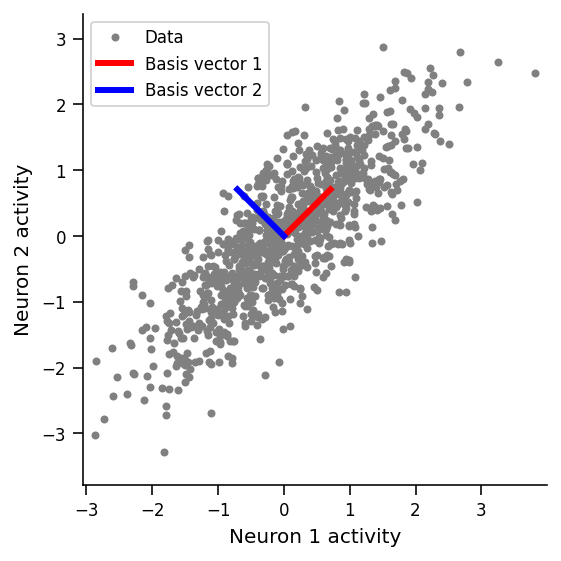

In [16]:
#################################################
# Fill out function and remove
#raise NotImplementedError("Student exercise: calculate and sort eigenvalues")
#################################################

# Calculate the eigenvalues and eigenvectors
evals, evectors = np.linalg.eigh(cov_matrix)

# Sort the eigenvalues in descending order
evals, evectors = sort_evals_descending(evals, evectors)

# Visualize
plot_basis_vectors(X, evectors)

---
# Section 2: Perform PCA by projecting data onto the eigenvectors

*Estimated timing to here from start of tutorial: 25 min*


To perform PCA, we will project the data onto the eigenvectors of the covariance matrix, i.e.,:

\begin{equation}
\bf S = X W
\end{equation}

where $\bf S$ is an $N_\text{samples} \times N$ matrix representing the projected data (also called *scores*), and $\bf W$ is an $N\times N$ orthogonal matrix, each of whose columns represents the eigenvectors of the covariance matrix (also called *weights* or *loadings*). 

## Coding Exercise 2: PCA implementation

You will now perform PCA on the data using the intuition and functions you have developed so far. Fill in the function below to carry out the steps to perform PCA by projecting the data onto the eigenvectors of its covariance matrix.

**Steps:**
* First subtract the mean and calculate the sample covariance matrix.
* Then find the eigenvalues and eigenvectors and sort them in descending order.
* Finally project the mean-centered data onto the eigenvectors.

In [ ]:
help(change_of_basis)

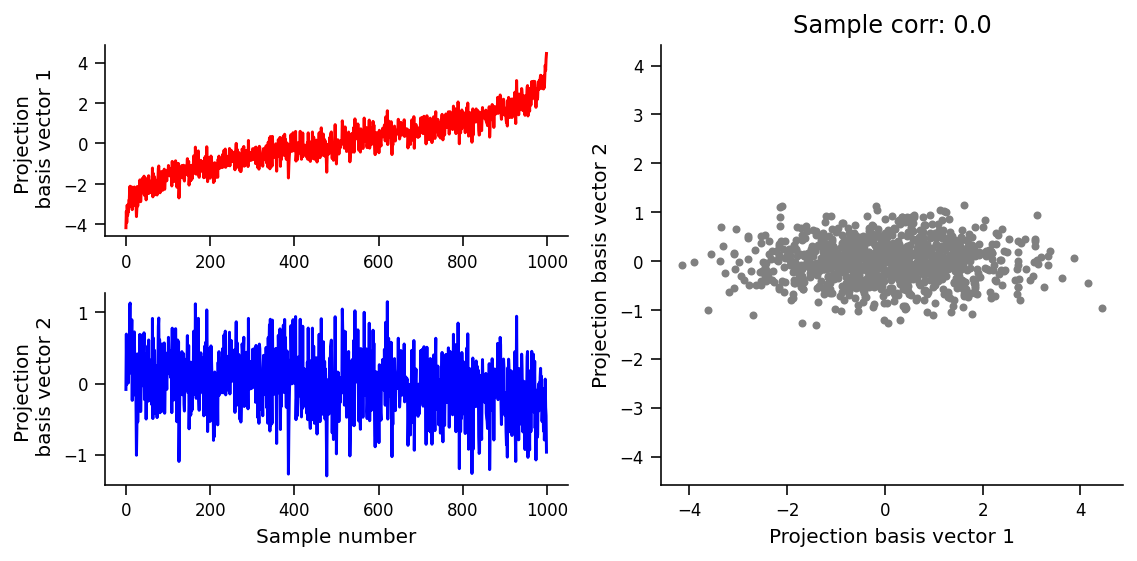

In [17]:
def pca(X):
  """
  Sorts eigenvalues and eigenvectors in decreasing order.

  Args:
    X (numpy array of floats): Data matrix each column corresponds to a
                               different random variable

  Returns:
    (numpy array of floats)  : Data projected onto the new basis
    (numpy array of floats)  : Vector of eigenvalues
    (numpy array of floats)  : Corresponding matrix of eigenvectors

  """

  #################################################
  # Fill out function and remove
  #raise NotImplementedError("Student exercise: sort eigenvalues/eigenvectors!")
  #################################################

  # Calculate the sample covariance matrix
  cov_matrix = get_sample_cov_matrix(X)

  # Calculate the eigenvalues and eigenvectors
  evals, evectors = np.linalg.eigh(cov_matrix)

  # Sort the eigenvalues in descending order
  evals, evectors = sort_evals_descending(evals, evectors)

  # Project the data onto the new eigenvector basis
  score = change_of_basis(X, evectors)

  return score, evectors, evals


# Perform PCA on the data matrix X
score, evectors, evals = pca(X)

# Plot the data projected into the new basis
plot_data_new_basis(score)

   Finally, we will examine the eigenvalues of the covariance matrix. Remember that each eigenvalue describes the variance of the data projected onto its corresponding eigenvector. This is an important concept because it allows us to rank the PCA basis vectors based on how much variance each one can capture. First run the code below to plot the eigenvalues (sometimes called the "scree plot"). Which eigenvalue is larger?

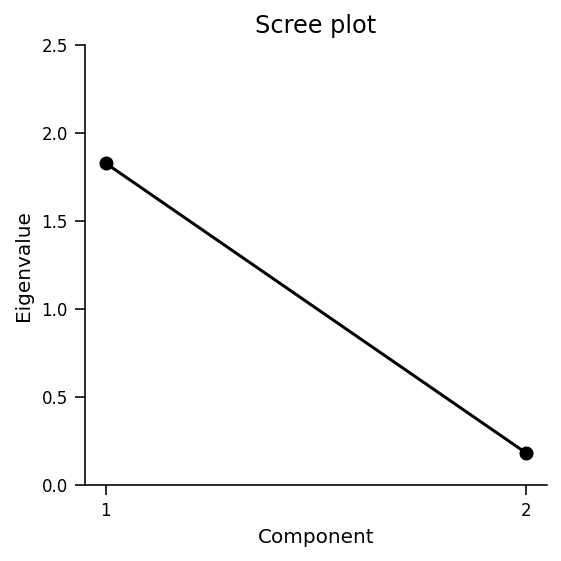

In [18]:
plot_eigenvalues(evals)

## Interactive Demo 2: Exploration of the correlation coefficient

Run the following cell and use the slider to change the correlation coefficient in the data. You should see the scree plot and the plot of basis vectors updated.

1.  What happens to the eigenvalues as you change the correlation coefficient?
2.  Can you find a value for which both eigenvalues are equal?
3.  Can you find a value for which only one eigenvalue is nonzero?

In [19]:
# @markdown Make sure you execute this cell to enable the widget!

def refresh(corr_coef=.8):
  cov_matrix = calculate_cov_matrix(variance_1, variance_2, corr_coef)
  X = get_data(cov_matrix)
  score, evectors, evals = pca(X)
  plot_eigenvalues(evals)
  plot_basis_vectors(X, evectors)


_ = widgets.interact(refresh, corr_coef=(-1, 1, .1))

interactive(children=(FloatSlider(value=0.8, description='corr_coef', max=1.0, min=-1.0), Output()), _dom_clas…

In [ ]:
# to_remove explanation

"""

1) As the absolute value of the correlation coefficient decreases, the two eigenvalues
become more similar (closer in value)

2) The two eigenvalues are extremely similar (basically equal) with a correlation coefficient of 0.

3) A correlation coefficient of 1 or -1 results in only one non-zero eigenvalues.

"""

---
# Summary

*Estimated timing of tutorial: 45 minutes*

- In this tutorial, we learned that the goal of PCA is to find an orthonormal basis capturing the directions of maximum variance of the data. More precisely, the $i$th basis vector is the direction that maximizes the projected variance, while being orthogonal to all previous basis vectors. Mathematically, these basis vectors are the eigenvectors of the covariance matrix (also called *loadings*). 
- PCA also has the useful property that the projected data (*scores*) are uncorrelated.
- The projected variance along each basis vector is given by its corresponding eigenvalue. This is important because it allows us to rank the "importance" of each basis vector in terms of how much of the data variability it explains. An eigenvalue of zero means there is no variation along that direction so it can be dropped without losing any information about the original data.
- In the next tutorial, we will use this property to reduce the dimensionality of high-dimensional data.


---
# Notation

\begin{align}
\mathbf{x_i}  &\quad \text{all measurements of neuron } i\\
\bar{\bf x_i}  &\quad \text{mean across samples for neuron } i \\
\bf \Sigma &\quad \text{covariance matrix}\\
\bf \hat \Sigma &\quad \text{sample covariance matrix}\\
\bf W &\quad \text{weights, loadings matrix}\\
{\bf X} &\quad \text{original data matrix}\\
\bf S &\quad \text{projected matrix, scores}\\
N &\quad \text{data dimensionality}\\
N_\text{samples} &\quad \text{number of samples}\\
\end{align}

---
# Bonus

---
## Bonus Section 1: Mathematical basis of PCA properties

In [ ]:
# @title Video 2: Properties of PCA
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1xa4y1a77c", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="p56UrMRt6-U", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)